<a href="https://colab.research.google.com/github/the77hnx/works-in-the-univ/blob/main/mini_Proj_ML_for_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akrambelha","key":"3fa0e6738defaf8b34de873ff10cc191"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import pandas as pd

# Download the dataset from Kaggle
!kaggle datasets download -d kaustubhdikshit/neu-surface-defect-database --unzip -p /content

Dataset URL: https://www.kaggle.com/datasets/kaustubhdikshit/neu-surface-defect-database
License(s): unknown
 26% 7.00M/26.4M [00:00<00:00, 68.6MB/s]
100% 26.4M/26.4M [00:00<00:00, 162MB/s] 


In [ ]:
import os
from PIL import Image
import numpy as np

# تحديد حجم الصورة المرغوب (على سبيل المثال، 128x128)
image_size = (128, 128)

# مسارات الفئات داخل مجلد train
base_path = "/content/NEU-DET/train/images"
categories = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]

# قائمة لتخزين الصور وملصقاتها
images = []
labels = []

# تحميل الصور الرمادية وتنفيذ المعالجة المسبقة
for category in categories:
    category_path = os.path.join(base_path, category)
    label = categories.index(category)  # تعيين رقم لكل فئة

    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)

        # تحميل الصورة بتدرجات الرمادي
        image = Image.open(file_path).convert("L")  # "L" لتحميل الصورة بتدرجات الرمادي

        # تغيير الحجم
        image = image.resize(image_size)

        # تحويل الصورة إلى مصفوفة numpy وتطبيع القيم
        image_array = np.array(image) / 255.0  # تطبيع القيم بين 0 و 1

        # إضافة الصورة والملصق للقوائم
        images.append(image_array)
        labels.append(label)

# تحويل القوائم إلى مصفوفات numpy
images = np.array(images)
labels = np.array(labels)

# إعادة تشكيل الصور لإضافة قناة واحدة (إذا كنت تستخدم شبكات عصبية تحتاج إلى شكل قنوات محدد)
images = images.reshape(-1, image_size[0], image_size[1], 1)

print("تم تحميل الصور الرمادية ومعالجتها بنجاح")
print("شكل الصور:", images.shape)
print("شكل الملصقات:", labels.shape)


تم تحميل الصور الرمادية ومعالجتها بنجاح
شكل الصور: (1440, 128, 128, 1)
شكل الملصقات: (1440,)


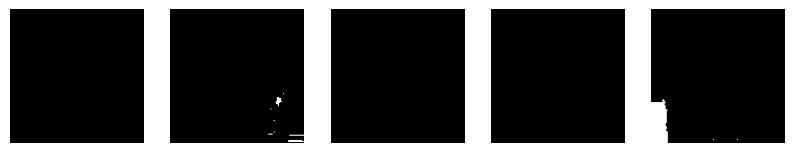

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# إعداد ImageDataGenerator مع تقنيات Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,         # التدوير العشوائي بين 0 و20 درجة
    width_shift_range=0.2,     # الإزاحة العرضية بنسبة 20%
    height_shift_range=0.2,    # الإزاحة الطولية بنسبة 20%
    zoom_range=0.2,            # التكبير أو التصغير بنسبة تصل إلى 20%
    horizontal_flip=True,      # الانعكاس الأفقي
    brightness_range=[0.8, 1.2]  # تغيير السطوع بين 80% و 120%
)

# مثال على تطبيق الـ Augmentation
# إعادة تشكيل الصور في شكل يوافق ImageDataGenerator (أي بدون القناة الأخيرة)
images_no_channel = images.reshape(-1, image_size[0], image_size[1])

# تجهيز generator للصور والملصقات
datagen.fit(images_no_channel[..., np.newaxis])  # إضافة قناة واحدة للشكل

# عرض بعض الصور المعززة للتأكد من صحة التطبيق
import matplotlib.pyplot as plt

# استخراج بعض العينات المعززة لعرضها
sample_images, sample_labels = next(datagen.flow(images, labels, batch_size=5))

# عرض الصور
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_images[i].reshape(image_size[0], image_size[1]), cmap="gray")
    plt.axis('off')
plt.show()


In [ ]:
# إعادة تحديد حجم الصور إلى أبعاد أقل إذا لزم الأمر، مثل 64x64
optimized_image_size = (64, 64)

# تغيير حجم جميع الصور في مجموعة البيانات
optimized_images = np.array([Image.fromarray((img * 255).astype(np.uint8).reshape(image_size)).resize(optimized_image_size) for img in images])
optimized_images = np.array([np.array(img) / 255.0 for img in optimized_images])
optimized_images = optimized_images.reshape(-1, optimized_image_size[0], optimized_image_size[1], 1)

print("تم تحسين دقة الصور بنجاح.")
print("شكل الصور بعد تحسين الدقة:", optimized_images.shape)


تم تحسين دقة الصور بنجاح.
شكل الصور بعد تحسين الدقة: (1440, 64, 64, 1)


In [ ]:
import numpy as np
from collections import Counter

# حساب توزيع الفئات
label_counts = Counter(labels)
print("توزيع الفئات قبل التوازن:", label_counts)


توزيع الفئات قبل التوازن: Counter({0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240})


In [ ]:
# إعداد Augmentation للفئات الناقصة فقط
balanced_images = []
balanced_labels = []

for category in categories:
    category_index = categories.index(category)
    category_images = images[labels == category_index]

    # الحصول على عدد العينات المطلوبة لتحقيق التوازن
    max_count = max(label_counts.values())
    additional_samples = max_count - label_counts[category_index]

    if additional_samples > 0:
        # Augmentation للفئة الناقصة
        augmented_images, augmented_labels = next(datagen.flow(category_images, np.full(len(category_images), category_index), batch_size=additional_samples))

        # إضافة العينات الأصلية والمعززة إلى القائمة
        balanced_images.extend(category_images)
        balanced_labels.extend([category_index] * len(category_images))
        balanced_images.extend(augmented_images)
        balanced_labels.extend(augmented_labels)
    else:
        # إضافة العينات الأصلية إذا كانت الفئة متوازنة
        balanced_images.extend(category_images)
        balanced_labels.extend([category_index] * len(category_images))

# تحويل القوائم إلى مصفوفات numpy
balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)

print("تم توازن مجموعة البيانات بنجاح.")
print("شكل الصور بعد التوازن:", balanced_images.shape)
print("توزيع الفئات بعد التوازن:", Counter(balanced_labels))


تم توازن مجموعة البيانات بنجاح.
شكل الصور بعد التوازن: (1440, 128, 128, 1)
توزيع الفئات بعد التوازن: Counter({0: 240, 1: 240, 2: 240, 3: 240, 4: 240, 5: 240})


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf # Import TensorFlow

# تغيير حجم الصور إلى 64x64
target_size = (64, 64)
resized_balanced_images = np.array([tf.image.resize(img, target_size).numpy() for img in balanced_images])

print("تم تغيير حجم الصور بنجاح.")
print("شكل الصور الجديدة:", resized_balanced_images.shape)

تم تغيير حجم الصور بنجاح.
شكل الصور الجديدة: (1440, 64, 64, 1)


In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing import image

# تحديد المجلدات التي تحتوي على الصور
image_directory = "/content/NEU-DET/validation/images"

# تحضير قائمة الصور
image_paths = []
labels = []  # هنا يمكن تخزين التسميات الخاصة بكل صورة

# استعراض الصور في كل تصنيف وتحميلها
for category in os.listdir(image_directory):
    category_path = os.path.join(image_directory, category)
    if os.path.isdir(category_path):  # التأكد من أن المسار هو مجلد
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = image.load_img(img_path, color_mode='grayscale', target_size=(128, 128))  # تحميل الصورة
            img_array = image.img_to_array(img) / 255.0  # تحويل الصورة إلى مصفوفة
            image_paths.append(img_array)
            labels.append(category)  # استخدام التصنيف كعلامة

# تحويل الصور إلى مصفوفة NumPy
test_images = np.array(image_paths)
test_labels = np.array(labels)

# التأكد من الشكل النهائي للصور
print(f"شكل بيانات الصور: {test_images.shape}")
print(f"شكل بيانات التسميات: {test_labels.shape}")

شكل بيانات الصور: (360, 128, 128, 1)
شكل بيانات التسميات: (360,)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# تحويل التسميات النصية إلى أرقام
label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_labels)

print(f"التسميات بعد التشفير: {test_labels}")


التسميات بعد التشفير: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
# إذا كنت قد قمت بتغيير حجم الصور أثناء التحضير، تأكد من تطبيق نفس المعالجة على بيانات الاختبار
# على سبيل المثال، إعادة تحجيم الصور في مجموعة الاختبار إلى نفس الحجم المستخدم في التدريب:
test_images_resized = np.array([tf.image.resize(img, target_size).numpy() for img in test_images])

# تأكد من أن البيانات تم تنسيقها بشكل صحيح
print("شكل بيانات الاختبار:", test_images_resized.shape)



شكل بيانات الاختبار: (360, 64, 64, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# تحميل نموذج MobileNet مع إزالة الطبقات العليا (top layers) حتى نستطيع تخصيصها
base_model = MobileNet(input_shape=(64, 64, 1), include_top=False, weights=None)  # None لتحميله بدون وزن مسبق

# إضافة طبقات للتصنيف
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(len(categories), activation='softmax')(x)

# بناء النموذج الكامل
mobile_model = Model(inputs=base_model.input, outputs=output_layer)
mobile_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("تم بناء نموذج MobileNet بنجاح")


تم بناء نموذج MobileNet بنجاح


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# تحميل نموذج EfficientNetB0 (النسخة الأساسية) مع إزالة الطبقات العليا
base_model = EfficientNetB0(input_shape=(64, 64, 1), include_top=False, weights=None)

# إضافة طبقات للتصنيف
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(len(categories), activation='softmax')(x)

# بناء النموذج الكامل
efficient_model = Model(inputs=base_model.input, outputs=output_layer)
efficient_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("تم بناء نموذج EfficientNet بنجاح")


تم بناء نموذج EfficientNet بنجاح


In [ ]:
from tensorflow.keras.applications import ResNet50

# تحميل نموذج ResNet50 بدون الطبقات العليا
base_model = ResNet50(input_shape=(64, 64, 1), include_top=False, weights=None)

# إضافة طبقات للتصنيف
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(len(categories), activation='softmax')(x)

# بناء النموذج الكامل
resnet_model = Model(inputs=base_model.input, outputs=output_layer)
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("تم بناء نموذج ResNet بنجاح")


تم بناء نموذج ResNet بنجاح


In [ ]:
from tensorflow.keras.callbacks import Callback

# إنشاء Callback مخصص
class AccuracyEqualCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # إذا كانت دقة التدريب تساوي دقة التحقق
        if logs.get('accuracy') == logs.get('val_accuracy'):
            print(f"\nتم الوصول إلى التساوي بين الدقة في التدريب والتوثيق في العصر {epoch+1}. إيقاف التدريب.")
            self.model.stop_training = True

# تدريب نموذج MobileNet مع EarlyStopping
print("تدريب نموذج MobileNet")
history_mobilenet = mobile_model.fit(resized_balanced_images, balanced_labels,
                                     batch_size=32, epochs=10,
                                     validation_split=0.2,
                                     callbacks=[AccuracyEqualCallback()])

# تدريب نموذج EfficientNet مع EarlyStopping
print("تدريب نموذج EfficientNet")
history_efficientnet = efficient_model.fit(resized_balanced_images, balanced_labels,
                                           batch_size=32, epochs=10,
                                           validation_split=0.2,
                                           callbacks=[AccuracyEqualCallback()])

# تدريب نموذج ResNet مع EarlyStopping
print("تدريب نموذج ResNet")
history_resnet = resnet_model.fit(resized_balanced_images, balanced_labels,
                                  batch_size=32, epochs=10,
                                  validation_split=0.2,
                                  callbacks=[AccuracyEqualCallback()])


تدريب نموذج MobileNet
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 33s 116ms/step - accuracy: 0.5391 - loss: 1.1814 - val_accuracy: 0.0000e+00 - val_loss: 2.3560
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7664 - loss: 0.6323 - val_accuracy: 0.0000e+00 - val_loss: 3.0117
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8625 - loss: 0.3925 - val_accuracy: 0.0000e+00 - val_loss: 3.6926
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9175 - loss: 0.2456 - val_accuracy: 0.0000e+00 - val_loss: 4.6688
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8912 - loss: 0.3185 - val_accuracy: 0.0000e+00 - val_loss: 5.1134
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9284 - loss: 0.2271 - val_accuracy: 0.0000e+00 - val_loss: 5.0013
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9254 - loss: 0.2255 - val_accuracy: 0.0000e+00 - val_loss: 5.1086
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accura

In [ ]:
# تقييم نموذج MobileNet
print("تقييم نموذج MobileNet:")
mobile_model.evaluate(test_images_resized, test_labels, batch_size=32)

# تقييم نموذج EfficientNet
print("تقييم نموذج EfficientNet:")
efficient_model.evaluate(test_images_resized, test_labels, batch_size=32)

# تقييم نموذج ResNet
print("تقييم نموذج ResNet:")
resnet_model.evaluate(test_images_resized, test_labels, batch_size=32)


تقييم نموذج MobileNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.1559 - loss: 3.1387
تقييم نموذج EfficientNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 433ms/step - accuracy: 0.2304 - loss: 5.4370
تقييم نموذج ResNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step - accuracy: 0.2038 - loss: 9.5311


[7.424453258514404, 0.22499999403953552]

In [ ]:
# تخزين الخسارة والدقة للتدريب والتحقق
train_loss_mobilenet = history_mobilenet.history['loss']
val_loss_mobilenet = history_mobilenet.history['val_loss']
train_acc_mobilenet = history_mobilenet.history['accuracy']
val_acc_mobilenet = history_mobilenet.history['val_accuracy']

train_loss_efficientnet = history_efficientnet.history['loss']
val_loss_efficientnet = history_efficientnet.history['val_loss']
train_acc_efficientnet = history_efficientnet.history['accuracy']
val_acc_efficientnet = history_efficientnet.history['val_accuracy']

train_loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']
train_acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']

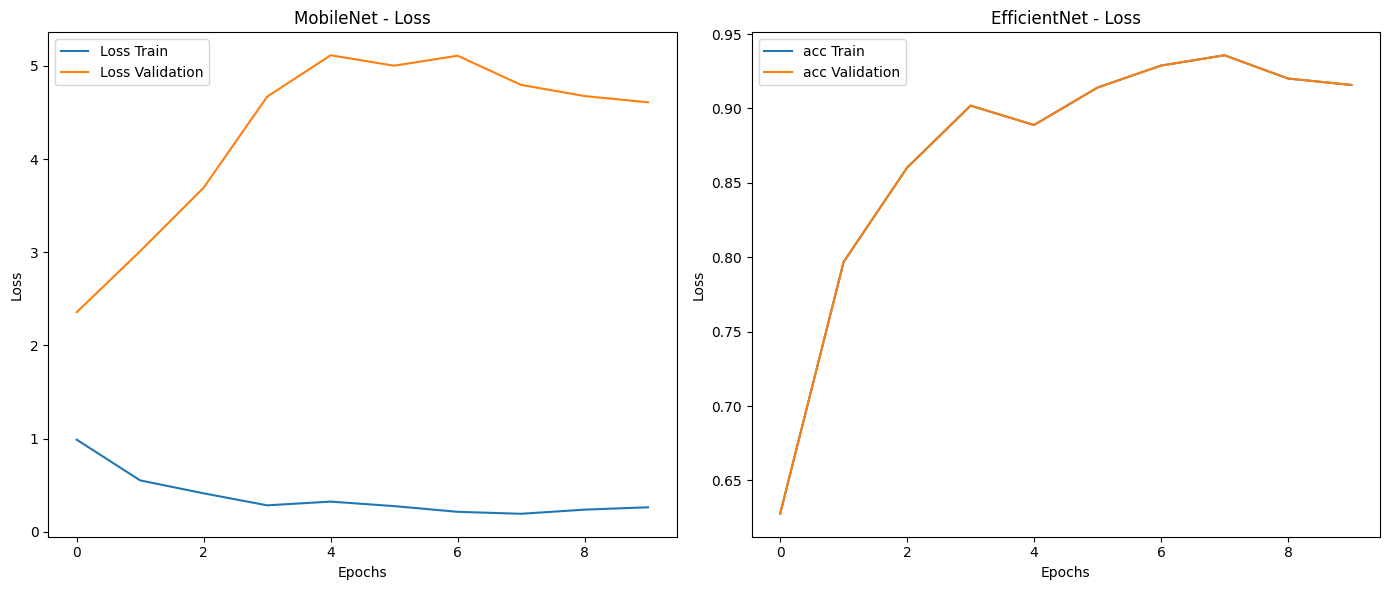

In [ ]:
import matplotlib.pyplot as plt

# رسم بياني لخسارة التدريب والتحقق لكل نموذج
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# رسم خسارة التدريب والتحقق لموديل MobileNet
ax[0].plot(train_loss_mobilenet, label='Loss Train')
ax[0].plot(val_loss_mobilenet, label='Loss Validation')
ax[0].set_title('MobileNet - Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# رسم خسارة التدريب والتحقق لموديل EfficientNet
ax[1].plot(train_acc_mobilenet, label='acc Train')
ax[1].plot(train_acc_mobilenet, label='acc Validation')
ax[1].set_title('EfficientNet - Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()



plt.tight_layout()
plt.show()


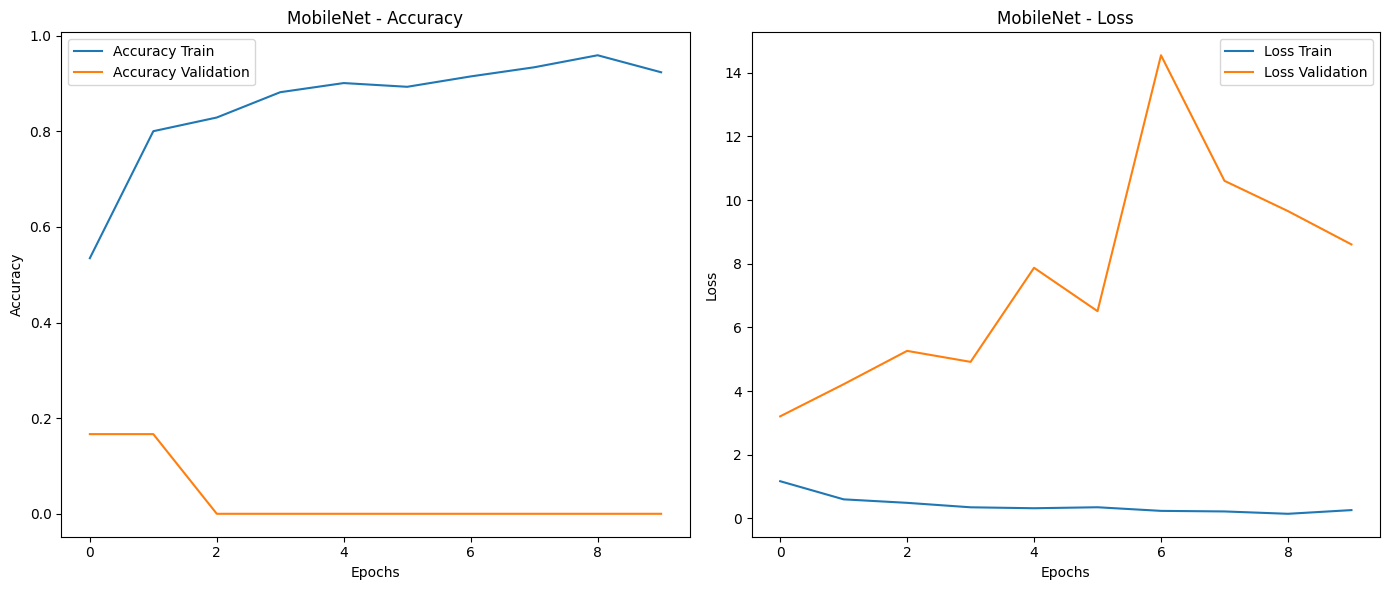

In [ ]:

# رسم بياني للدقة والخسارة لكل نموذج
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# رسم الدقة والخسارة لموديل MobileNet
ax[0].plot(train_acc_efficientnet, label='Accuracy Train')
ax[0].plot(val_acc_efficientnet, label='Accuracy Validation')
ax[0].set_title('MobileNet - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(train_loss_efficientnet, label='Loss Train')
ax[1].plot(val_loss_efficientnet, label='Loss Validation')
ax[1].set_title('MobileNet - Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


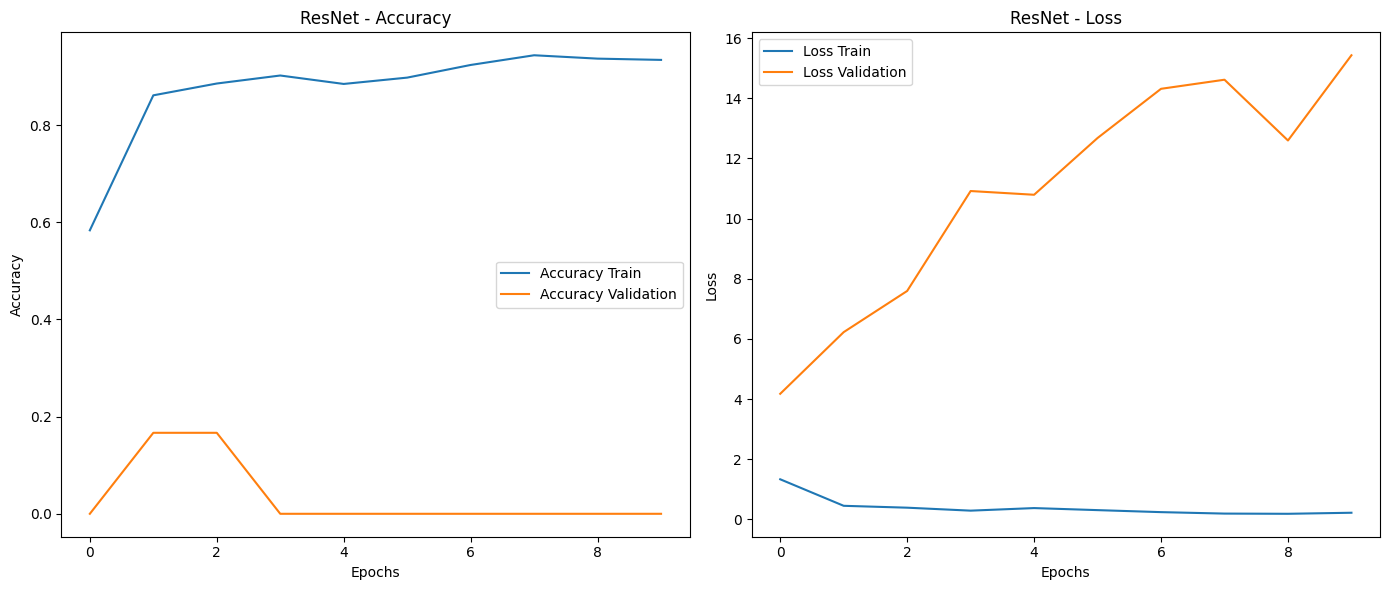

In [ ]:

# رسم بياني لكل من الدقة والخسارة لموديل ResNet
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# رسم الدقة والخسارة لموديل ResNet
ax[0].plot(train_acc_resnet, label='Accuracy Train')
ax[0].plot(val_acc_resnet, label='Accuracy Validation')
ax[0].set_title('ResNet - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(train_loss_resnet, label='Loss Train')
ax[1].plot(val_loss_resnet, label='Loss Validation')
ax[1].set_title('ResNet - Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# تحميل نموذج MobileNet مع إزالة الطبقات العليا (top layers) حتى نستطيع تخصيصها
base_model = MobileNet(input_shape=(64, 64, 1), include_top=False, weights=None)  # None لتحميله بدون وزن مسبق

# إضافة طبقات للتصنيف
x = base_model.output
x = GlobalAveragePooling2D()(x)

# إضافة BatchNormalization و Dropout لتحسين التعميم
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# الطبقة المخفية
x = Dense(128, activation='relu')(x)

# الطبقة النهائية
output_layer = Dense(len(categories), activation='softmax')(x)

# بناء النموذج الكامل
mobile_model = Model(inputs=base_model.input, outputs=output_layer)

# تجميع النموذج
mobile_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("تم بناء نموذج MobileNet بنجاح")

# إضافة EarlyStopping لتحسين التدريب
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# تدريب النموذج مع إيقاف التدريب المبكر
history_mobilenet = mobile_model.fit(
    resized_balanced_images,
    balanced_labels,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping]
)


تم بناء نموذج MobileNet بنجاح
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - accuracy: 0.4521 - loss: 1.6234 - val_accuracy: 0.0000e+00 - val_loss: 2.5334
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.7306 - loss: 0.7327 - val_accuracy: 0.0000e+00 - val_loss: 3.2444
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7819 - loss: 0.6302 - val_accuracy: 0.1667 - val_loss: 3.8818
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8671 - loss: 0.3842 - val_accuracy: 0.0000e+00 - val_loss: 4.1923
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8675 - loss: 0.4115 - val_accuracy: 0.1667 - val_loss: 4.9484
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8940 - loss: 0.2797 - val_accuracy: 0.1667 - val_loss: 5.6333


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# تحميل نموذج EfficientNet مع إزالة الطبقات العليا (top layers)
base_model_efficientnet = EfficientNetB0(input_shape=(64, 64, 1), include_top=False, weights=None)

# إضافة طبقات للتصنيف
x = base_model_efficientnet.output
x = GlobalAveragePooling2D()(x)

# إضافة BatchNormalization و Dropout لتحسين التعميم
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# الطبقة المخفية
x = Dense(128, activation='relu')(x)

# الطبقة النهائية
output_layer_efficientnet = Dense(len(categories), activation='softmax')(x)

# بناء النموذج الكامل
efficient_model = Model(inputs=base_model_efficientnet.input, outputs=output_layer_efficientnet)

# تجميع النموذج
efficient_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("تم بناء نموذج EfficientNet بنجاح")

# إضافة EarlyStopping لتحسين التدريب
early_stopping_efficientnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# تدريب النموذج مع إيقاف التدريب المبكر
history_efficientnet = efficient_model.fit(
    resized_balanced_images,
    balanced_labels,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping_efficientnet]
)


تم بناء نموذج EfficientNet بنجاح
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 80s 243ms/step - accuracy: 0.4489 - loss: 1.6060 - val_accuracy: 0.1667 - val_loss: 2.8165
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - accuracy: 0.7173 - loss: 0.7999 - val_accuracy: 0.1667 - val_loss: 3.5350
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7545 - loss: 0.6871 - val_accuracy: 0.1667 - val_loss: 4.3496
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8387 - loss: 0.4739 - val_accuracy: 0.1667 - val_loss: 4.3217
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8780 - loss: 0.3408 - val_accuracy: 0.1667 - val_loss: 5.0946
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.8877 - loss: 0.3307 - val_accuracy: 0.1667 - val_loss: 5.5138


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# تحميل نموذج ResNet مع إزالة الطبقات العليا (top layers)
base_model_resnet = ResNet50(input_shape=(64, 64, 1), include_top=False, weights=None)

# إضافة طبقات للتصنيف
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)

# إضافة BatchNormalization و Dropout لتحسين التعميم
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# الطبقة المخفية
x = Dense(128, activation='relu')(x)

# الطبقة النهائية
output_layer_resnet = Dense(len(categories), activation='softmax')(x)

# بناء النموذج الكامل
resnet_model = Model(inputs=base_model_resnet.input, outputs=output_layer_resnet)

# تجميع النموذج
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print("تم بناء نموذج ResNet بنجاح")

# إضافة EarlyStopping لتحسين التدريب
early_stopping_resnet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# تدريب النموذج مع إيقاف التدريب المبكر
history_resnet = resnet_model.fit(
    resized_balanced_images,
    balanced_labels,
    batch_size=32,
    epochs=10,
    validation_split=0.2,
    callbacks=[early_stopping_resnet]
)


تم بناء نموذج ResNet بنجاح
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.5031 - loss: 1.8885 - val_accuracy: 0.0938 - val_loss: 2.1094
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.8303 - loss: 0.5043 - val_accuracy: 0.1667 - val_loss: 3.0393
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8850 - loss: 0.3297 - val_accuracy: 0.0000e+00 - val_loss: 4.2405
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.8997 - loss: 0.3047 - val_accuracy: 0.1667 - val_loss: 3.7141
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9286 - loss: 0.2097 - val_accuracy: 0.1667 - val_loss: 4.6288
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9135 - loss: 0.2289 - val_accuracy: 0.0000e+00 - val_loss: 7.6359


In [ ]:
# تقييم نموذج MobileNet
print("تقييم نموذج MobileNet:")
mobile_model.evaluate(test_images_resized, test_labels, batch_size=32)

# تقييم نموذج EfficientNet
print("تقييم نموذج EfficientNet:")
efficient_model.evaluate(test_images_resized, test_labels, batch_size=32)

# تقييم نموذج ResNet
print("تقييم نموذج ResNet:")
resnet_model.evaluate(test_images_resized, test_labels, batch_size=32)

تقييم نموذج MobileNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.0418 - loss: 2.0935
تقييم نموذج EfficientNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 389ms/step - accuracy: 0.1559 - loss: 2.2453
تقييم نموذج ResNet:
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 187ms/step - accuracy: 0.0656 - loss: 1.9454


[1.91489839553833, 0.10000000149011612]

In [ ]:
# تخزين الخسارة والدقة للتدريب والتحقق
train_loss_mobilenet = history_mobilenet.history['loss']
val_loss_mobilenet = history_mobilenet.history['val_loss']
train_acc_mobilenet = history_mobilenet.history['accuracy']
val_acc_mobilenet = history_mobilenet.history['val_accuracy']

train_loss_efficientnet = history_efficientnet.history['loss']
val_loss_efficientnet = history_efficientnet.history['val_loss']
train_acc_efficientnet = history_efficientnet.history['accuracy']
val_acc_efficientnet = history_efficientnet.history['val_accuracy']

train_loss_resnet = history_resnet.history['loss']
val_loss_resnet = history_resnet.history['val_loss']
train_acc_resnet = history_resnet.history['accuracy']
val_acc_resnet = history_resnet.history['val_accuracy']

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.0418 - loss: 2.0934
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 504ms/step - accuracy: 0.1559 - loss: 2.2901
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.1071 - loss: 2.1205


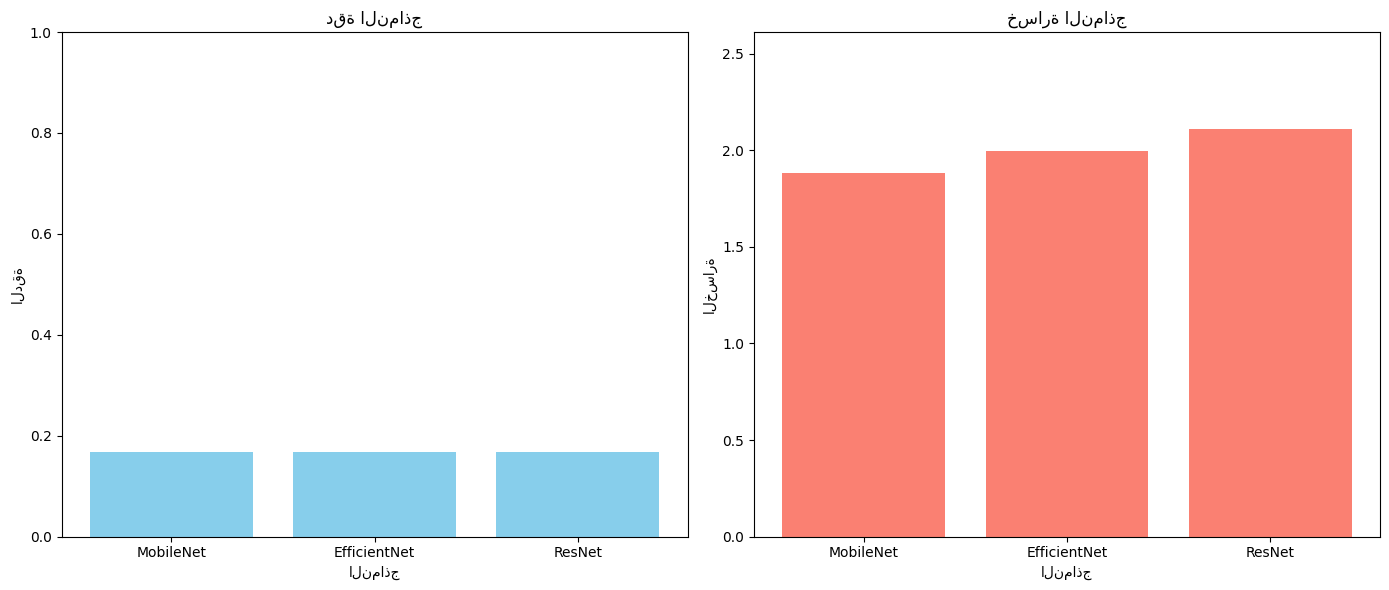

In [ ]:
import matplotlib.pyplot as plt

# تخزين نتائج التقييم لكل نموذج
models = ['MobileNet', 'EfficientNet', 'ResNet']
losses = []
accuracies = []

# تقييم النماذج
# MobileNet
loss_mobilenet, accuracy_mobilenet = mobile_model.evaluate(test_images, test_labels, batch_size=32)
losses.append(loss_mobilenet)
accuracies.append(accuracy_mobilenet)

# EfficientNet
loss_efficientnet, accuracy_efficientnet = efficient_model.evaluate(test_images, test_labels, batch_size=32)
losses.append(loss_efficientnet)
accuracies.append(accuracy_efficientnet)

# ResNet
loss_resnet, accuracy_resnet = resnet_model.evaluate(test_images, test_labels, batch_size=32)
losses.append(loss_resnet)
accuracies.append(accuracy_resnet)

# رسم الرسم البياني
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# رسم الدقة
ax[0].bar(models, accuracies, color='skyblue')
ax[0].set_title('دقة النماذج')
ax[0].set_ylabel('الدقة')
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('النماذج')

# رسم الخسارة
ax[1].bar(models, losses, color='salmon')
ax[1].set_title('خسارة النماذج')
ax[1].set_ylabel('الخسارة')
ax[1].set_ylim([0, max(losses) + 0.5])
ax[1].set_xlabel('النماذج')

# عرض الرسم البياني
plt.tight_layout()
plt.show()


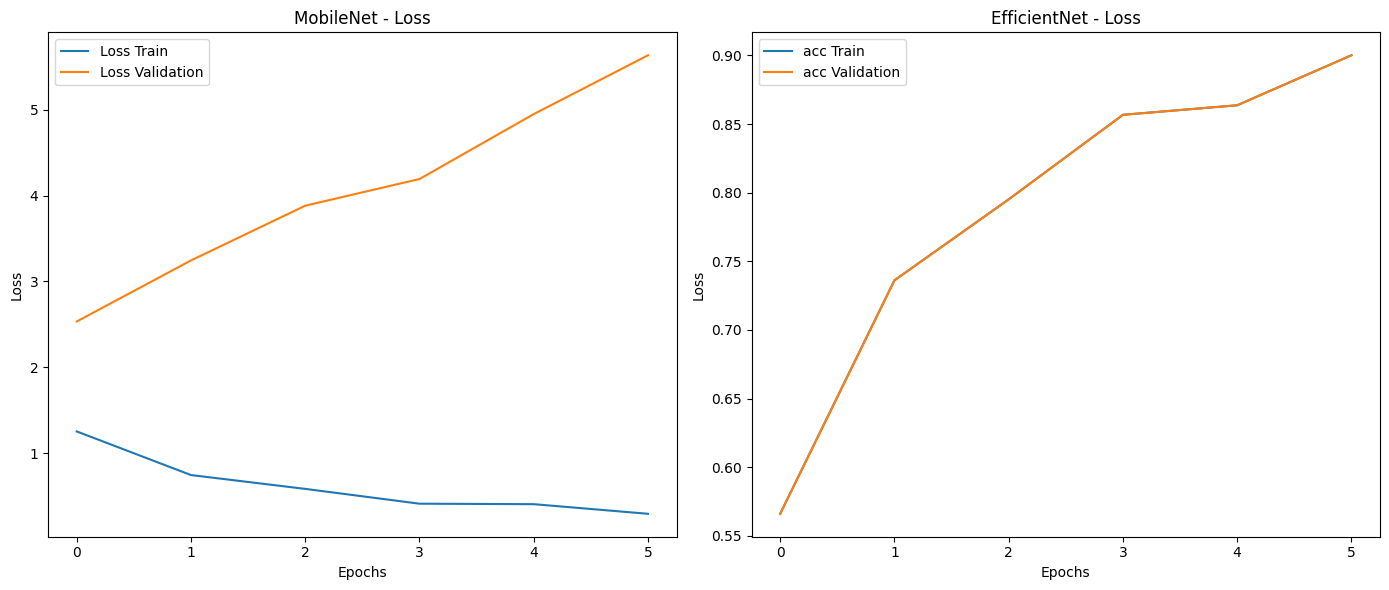

In [ ]:
import matplotlib.pyplot as plt

# رسم بياني لخسارة التدريب والتحقق لكل نموذج
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# رسم خسارة التدريب والتحقق لموديل MobileNet
ax[0].plot(train_loss_mobilenet, label='Loss Train')
ax[0].plot(val_loss_mobilenet, label='Loss Validation')
ax[0].set_title('MobileNet - Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# رسم خسارة التدريب والتحقق لموديل EfficientNet
ax[1].plot(train_acc_mobilenet, label='acc Train')
ax[1].plot(train_acc_mobilenet, label='acc Validation')
ax[1].set_title('EfficientNet - Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()



plt.tight_layout()
plt.show()


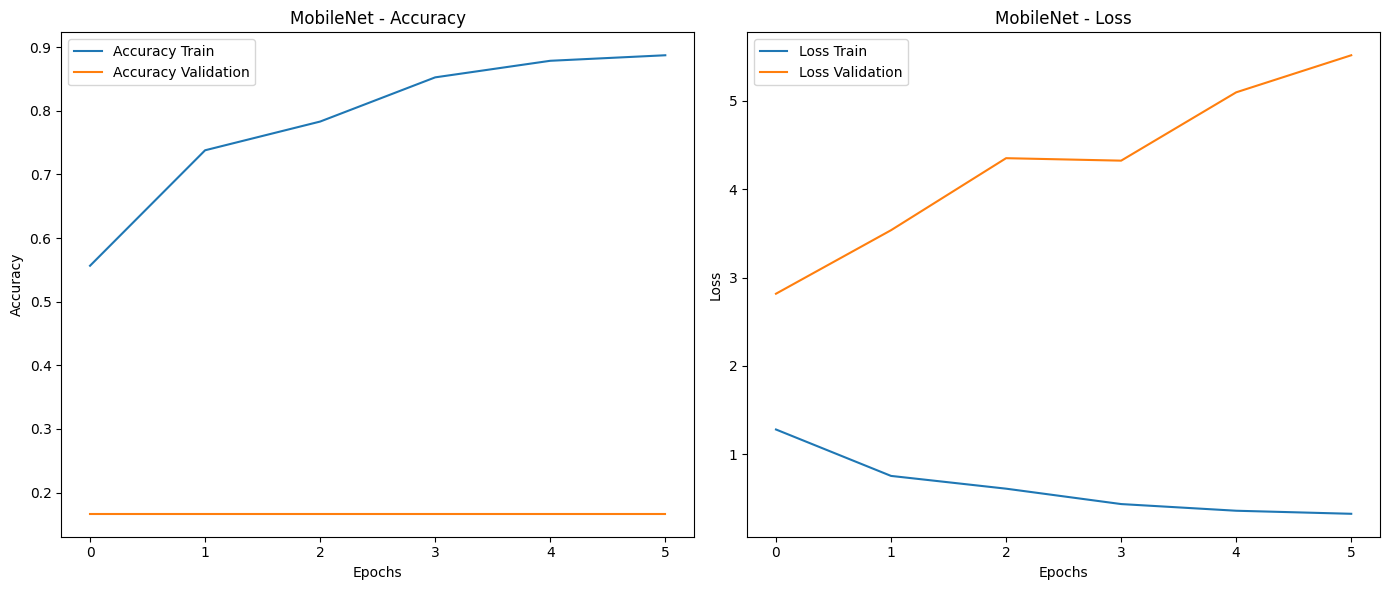

In [ ]:

# رسم بياني للدقة والخسارة لكل نموذج
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# رسم الدقة والخسارة لموديل MobileNet
ax[0].plot(train_acc_efficientnet, label='Accuracy Train')
ax[0].plot(val_acc_efficientnet, label='Accuracy Validation')
ax[0].set_title('MobileNet - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(train_loss_efficientnet, label='Loss Train')
ax[1].plot(val_loss_efficientnet, label='Loss Validation')
ax[1].set_title('MobileNet - Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


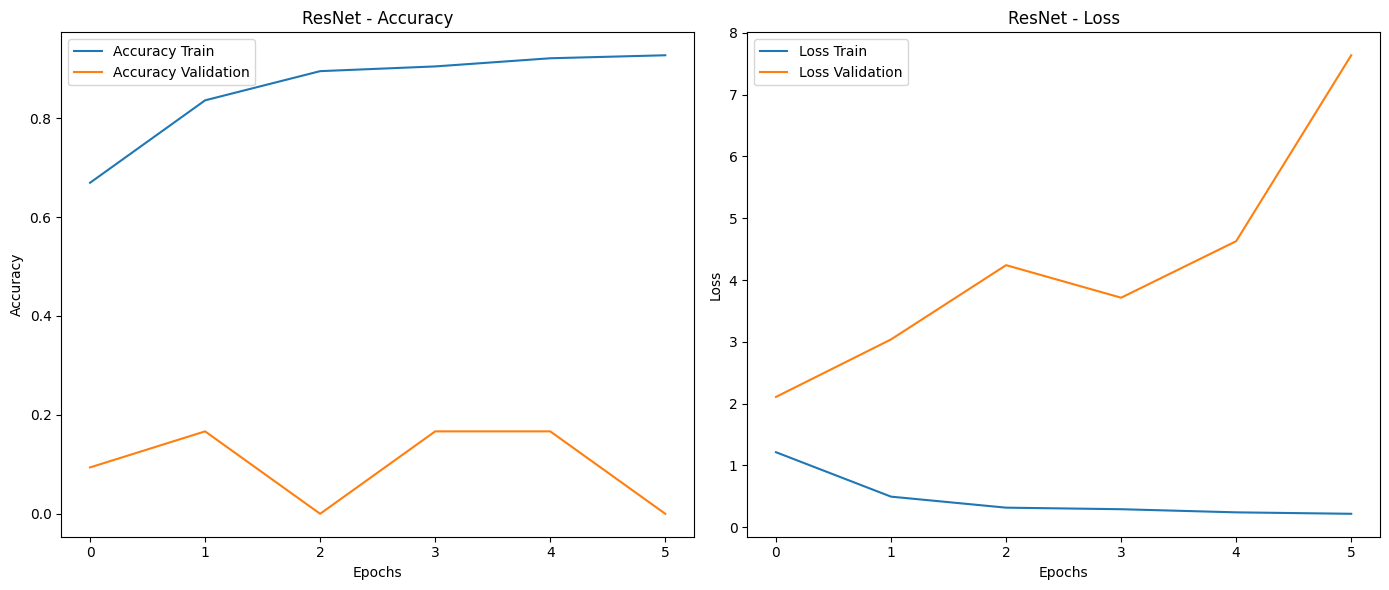

In [ ]:

# رسم بياني لكل من الدقة والخسارة لموديل ResNet
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# رسم الدقة والخسارة لموديل ResNet
ax[0].plot(train_acc_resnet, label='Accuracy Train')
ax[0].plot(val_acc_resnet, label='Accuracy Validation')
ax[0].set_title('ResNet - Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(train_loss_resnet, label='Loss Train')
ax[1].plot(val_loss_resnet, label='Loss Validation')
ax[1].set_title('ResNet - Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
!pip install tensorflow-model-optimization

In [ ]:
import tensorflow_model_optimization as tfmot


# تطبيق تقنية Pruning على النموذج (MobileNet كاختيار)
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# تحديد نسبة التقليم
pruning_params = {
'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
final_sparsity=0.80,
begin_step=0,
end_step=100)
}
# Ensure mobile_model is a tf.keras.Model
# mobile_model = tf.keras.Model(inputs=mobile_model.inputs, outputs=mobile_model.outputs)

# تفعيل تقنية Pruning على نموذج MobileNet
pruned_model =  tfmot.sparsity.keras.prune_low_magnitude(mobile_model, **pruning_params)

# تجميع النموذج
pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# تدريب النموذج
history_pruned = pruned_model.fit(
    resized_balanced_images,
    balanced_labels,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
)

ValueError: `prune_low_magnitude` can only prune an object of the following types: keras.models.Sequential, keras functional model, keras.layers.Layer, list of keras.layers.Layer. You passed an object of type: Functional.

In [ ]:
# تطبيق Quantization على النموذج بعد التدرب
converter = tf.lite.TFLiteConverter.from_keras_model(mobile_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# تحويل النموذج إلى تنسيق TFLite مع تكميم
quantized_tflite_model = converter.convert()

# حفظ النموذج المكمل إلى ملف TFLite
with open('quantized_model.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
print("تم تكميم النموذج بنجاح وحفظه بصيغة TFLite.")


Saved artifact at '/tmp/tmpi14z_z_5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name='keras_tensor_507')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  140481851516080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140477174930368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140477174935648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140477174931600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140477174934944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140477174938464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140476400340480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140476400337840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140476400338192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140476400337312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140476400343

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# إجراء التنبؤات باستخدام النموذج الأصلي
original_preds = mobile_model.predict(test_images_resized)
original_preds_labels = np.argmax(original_preds, axis=1)

# إجراء التنبؤات باستخدام النموذج بعد Pruning
# pruned_preds = pruned_model.predict(test_images_resized)
# pruned_preds_labels = np.argmax(pruned_preds, axis=1)

# إجراء التنبؤات باستخدام النموذج بعد Quantization
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
interpreter.allocate_tensors()

# إعداد الدالة لتوقعات النموذج المكمم
def predict_with_quantized_model(interpreter, test_images):
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    preds = []
    for img in test_images:
        interpreter.set_tensor(input_index, img.reshape(1, 64, 64, 1))
        interpreter.invoke()
        preds.append(interpreter.get_tensor(output_index))
    return np.argmax(np.array(preds).squeeze(), axis=-1)

quantized_preds_labels = predict_with_quantized_model(interpreter, test_images_resized)

# حساب المقاييس (F1-Score, Precision, Recall, ROC-AUC) لكل نموذج
print("Original Model Performance:")
print(classification_report(test_labels, original_preds_labels))
print("ROC-AUC:", roc_auc_score(test_labels, original_preds, multi_class='ovo'))

#print("\nPruned Model Performance:")
#print(classification_report(test_labels, pruned_preds_labels))
#print("ROC-AUC:", roc_auc_score(test_labels, pruned_preds, multi_class='ovo'))

print("\nQuantized Model Performance:")
print(classification_report(test_labels, quantized_preds_labels))
print("ROC-AUC:", roc_auc_score(test_labels, original_preds, multi_class='ovo'))
# Note: For ROC-AUC, Quantized model requires a workaround depending on implementation


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Original Model Performance:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        60
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        60

    accuracy                           0.17       360
   macro avg       0.03      0.17      0.05       360
weighted avg       0.03      0.17      0.05       360

ROC-AUC: 0.5002777777777777

Quantized Model Performance:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29        60
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        60
           4       0.00      0.00      0.00        60
       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [ ]:
import time

# وقت الاستدلال للنموذج الأصلي
start_time = time.time()
_ = mobile_model.predict(test_images_resized)
original_inference_time = time.time() - start_time

# وقت الاستدلال للنموذج بعد Pruning
start_time = time.time()
_ = pruned_model.predict(test_images_resized)
pruned_inference_time = time.time() - start_time

# وقت الاستدلال للنموذج بعد Quantization
start_time = time.time()
_ = predict_with_quantized_model(interpreter, test_images_resized)
quantized_inference_time = time.time() - start_time

print(f"Inference Time - Original: {original_inference_time:.4f}s, Pruned: {pruned_inference_time:.4f}s, Quantized: {quantized_inference_time:.4f}s")


In [ ]:
import os

# حجم النموذج الأصلي
original_model_size = os.path.getsize("original_model.h5") / 1024 / 1024  # بالميجابايت

# حجم النموذج بعد Pruning
pruned_model_size = os.path.getsize("pruned_model.h5") / 1024 / 1024  # بالميجابايت

# حجم النموذج بعد Quantization
quantized_model_size = os.path.getsize("quantized_model.tflite") / 1024 / 1024  # بالميجابايت

print(f"Model Size (MB) - Original: {original_model_size:.2f}MB, Pruned: {pruned_model_size:.2f}MB, Quantized: {quantized_model_size:.2f}MB")
